In [3]:
!pip3 install scikit-surprise
! pip install papermill
! pip install recommenders[examples,gpu]

In [4]:
import pandas as pd
import numpy as np
from recommenders.datasets.split_utils import min_rating_filter_pandas
import surprise
from surprise import Reader
from surprise import Dataset
from surprise import KNNBaseline
from surprise.accuracy import rmse
from surprise import accuracy
from recommenders.utils.python_utils import binarize
from collections import defaultdict
import random
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k, get_top_k_items)
from recommenders.models.surprise.surprise_utils import predict, compute_ranking_predictions
from recommenders.datasets.python_splitters import python_random_split
from recommenders.utils.timer import Timer
from surprise.model_selection import train_test_split


In [5]:
df = pd.DataFrame()
df[["userID", "itemID", "rating"]] = pd.read_json("/content/AMAZON_FASHION_5.71.268 (1).json")[["userID", "itemID", "rating"]]
df.head()

,userID,itemID,rating
10,A3HX4X3TIABWOV,B000KPIHQ4,2
17,A3HX4X3TIABWOV,B000V0IBDM,2
24,A3QY3THQ42WSCQ,B000YFSR5G,1
25,AGZ5OOZVDO194,B000YFSR5G,5
26,A3GJ3DJU1RXOHN,B000YFSR4W,4


In [6]:
df.shape

(3010, 3)

In [7]:
df['rating'].value_counts()

5    2072
4     443
3     310
1     109
2      76
Name: rating, dtype: int64

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.head

<bound method NDFrame.head of               userID      itemID  rating
10    A3HX4X3TIABWOV  B000KPIHQ4       2
17    A3HX4X3TIABWOV  B000V0IBDM       2
24    A3QY3THQ42WSCQ  B000YFSR5G       1
25     AGZ5OOZVDO194  B000YFSR5G       5
26    A3GJ3DJU1RXOHN  B000YFSR4W       4
...              ...         ...     ...
3171  A2077NII5H62R2  B005AGO4LU       5
3172  A2IBS6PIPAGAB5  B005AGO4LU       5
3173  A1GTC5EVSJNCQ8  B005AGO4LU       5
3174  A311XHHLM12MUT  B005AGO4LU       5
3175  A135SGOQMVWABQ  B005AGO4LU       5

[3010 rows x 3 columns]>

In [10]:
sparsity = lambda dataf: dataf.isna().sum().sum() / (dataf.shape[0] * dataf.shape[1])

In [11]:
usercount = df[['userID']].groupby('userID', as_index = False).size()
itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

density = 1. * df.shape[0] / (usercount.shape[0] * itemcount.shape[0])

print("After filtering, there are %d ratings from %d users on %d products (sparsity: %.3f%%)" % 
      (df.shape[0], usercount.shape[0], itemcount.shape[0], (1 - density) * 100))


After filtering, there are 3010 ratings from 388 users on 27 products (sparsity: 71.268%)


In [12]:
df.rating.value_counts()

5    2072
4     443
3     310
1     109
2      76
Name: rating, dtype: int64

In [13]:
df.shape

(3010, 3)

# Initial Run of the Algorithm

In [14]:
train, test = python_random_split(df, 0.8)

In [15]:
reader = Reader(rating_scale=(1,5),)
train_set = Dataset.load_from_df(train[['userID', 'itemID', 'rating']], reader)

In [16]:
test_set= Dataset.load_from_df(test[['userID', 'itemID', 'rating']], reader)

In [17]:
param_grid = {'k': [1, 2, 5, 10, 20], 'min_k': [1, 2, 5, 10, 20]}
gs = GridSearchCV(KNNBaseline, param_grid, cv=5)
gs.fit(train_set)



Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [18]:
sim_options = {'name': 'pearson_baseline',
               'user_based': False}
knn = KNNBaseline(k=gs.best_params['rmse']['k'], min_k=gs.best_params['rmse']['min_k'], sim_options=sim_options)
knn.fit(train_set.build_full_trainset())

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [19]:
predictions = predict(knn, test, usercol='userID', itemcol='itemID')
predictions.head()

,userID,itemID,prediction
0,ASOSP4VAUDB7I,B014IBJKNO,4.006458
1,A140XVPLRQYKYY,B0058YEJ5K,4.003481
2,ATSUXY7ASCGPY,B014IBJKNO,4.004878
3,A1S4O68F0UG4GA,B001IKJOLW,4.993395
4,A2CP5A30XO5JUO,B009MA34NY,5.000000


In [20]:
with Timer() as test_time:
    all_predictions = compute_ranking_predictions(knn, train, usercol='userID', itemcol='itemID', remove_seen=True)
    
print("Took {} seconds for prediction.".format(test_time.interval))

Took 0.2148877499998889 seconds for prediction.


In [21]:
all_predictions

,userID,itemID,prediction
2408,A1EE1EP2G0HKQ,B014IBJKNO,4.995683
2409,A1EE1EP2G0HKQ,B005AGO4LU,4.965926
2410,A1EE1EP2G0HKQ,B000YFSR5G,4.335407
2411,A1EE1EP2G0HKQ,B00I0VHS10,5.000000
2412,A1EE1EP2G0HKQ,B00ND9047Y,4.677891
...,...,...,...
9307,A3JGWZXFBDENRB,B01H7KY678,4.095175
9308,A3JGWZXFBDENRB,B0014F8TIU,4.158615
9309,A3JGWZXFBDENRB,B00MLYE8PQ,4.090442
9310,A3JGWZXFBDENRB,B00LKWYX2I,4.175820


In [22]:
eval_rmse = rmse(test, predictions)
eval_mae = mae(test, predictions)
eval_rsquared = rsquared(test, predictions)
eval_exp_var = exp_var(test, predictions)

k = 10
eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=k)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=k)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=k)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=k)


print("RMSE:\t\t%f" % eval_rmse,
      "MAE:\t\t%f" % eval_mae,
      "rsquared:\t%f" % eval_rsquared,
      "exp var:\t%f" % eval_exp_var, sep='\n')

print('----')

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

RMSE:		0.139930
MAE:		0.020032
rsquared:	0.981423
exp var:	0.981431
----
MAP:	0.550510
NDCG:	0.590767
Precision@K:	0.127273
Recall@K:	0.669801


In [23]:
newTable = PrettyTable(["Algorithm", "Sparsity", "Precision@k", "Recall@k", "NDCG@k", "MAP@k"]) 
sparse=0.70
newTable.add_row(["KNN_Baseline", sparse, eval_precision , eval_recall, eval_ndcg, eval_map])   
print(newTable)

+--------------+----------+--------------------+--------------------+--------------------+--------------------+
|  Algorithm   | Sparsity |    Precision@k     |      Recall@k      |       NDCG@k       |       MAP@k        |
+--------------+----------+--------------------+--------------------+--------------------+--------------------+
| KNN_Baseline |   0.7    | 0.1272727272727273 | 0.6698014629049113 | 0.5907667786999632 | 0.5505102751654476 |
+--------------+----------+--------------------+--------------------+--------------------+--------------------+


# Model Pipeline Functions

In [24]:
def _print(message, verbose):
    if verbose:
        print(message)
    

def load_dataset(fp):
    df = pd.DataFrame()
    try:
        df[["userID", "itemID", "rating"]] = pd.read_json(fp)[["userID", "itemID", "rating"]]
    except:
        df = pd.read_json(fp)
    return df


def filter_to_sparsity(df, sparsity_percentage, verbose = False):
    # Obtain both usercount and itemcount after filtering
    usercount = df[['userID']].groupby('userID', as_index = False).size()
    itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

    sparsity = 1 - (df.shape[0] / (usercount.shape[0] * itemcount.shape[0]))

    _print(f"After filtering, there are {df.shape[0]} ratings from {usercount.shape[0]} users on {itemcount.shape[0]}" + 
           f" products (sparsity: {sparsity * 100:.3f})", verbose)
    
    drop_item_ratings = int(-((1-sparsity_percentage) * (usercount.shape[0] * itemcount.shape[0]) - df.shape[0]))
    print(f"To obtain a sparsity of {sparsity_percentage * 100}% we need to drop {drop_item_ratings} ratings")
    drop_indices = np.random.choice(df.index, size=drop_item_ratings)
    df.drop(drop_indices, inplace=True)

    sparsity = 1 - (df.shape[0] / (usercount.shape[0] * itemcount.shape[0]))
    _print(f"After dropping cells, there are {df.shape[0]} ratings from {usercount.shape[0]} users on {itemcount.shape[0]}" + 
           f" products (sparsity: {sparsity * 100:.3f})", verbose)
    return df


In [25]:
def data_loading_pipeline(fp, sparsity_percentage=None, with_writing=False):
    """
    fp: str = Filepointer to desired user-item-ratings json.
    sparsity_percentage: float = value between 0-1.
    """
    df = load_dataset(fp)
    #df = filter_on_minimal_ratings(df)
    df = filter_to_sparsity(df, sparsity_percentage)
    
    return df




In [26]:
metrics_at_sparsity_levels = dict()
json_dict = dict()

In [27]:
pr=[]
re=[]
nd=[]
mp=[]

for i in range(20):

  sparsity_percentage = 0.75
  df = data_loading_pipeline("/content/AMAZON_FASHION_5.71.268 (1).json", sparsity_percentage)

  train, test = python_random_split(df, 0.8)

  reader = Reader(rating_scale=(1,5),)
  train_set = Dataset.load_from_df(train[['userID', 'itemID', 'rating']], reader)

  
  

  sim_options = {'name': 'pearson_baseline',
               'user_based': False  
               }

  param_grid = {'k': [1, 2, 5, 10, 20], 'min_k': [1, 2, 5, 10, 20]}
  gs = GridSearchCV(KNNBaseline, param_grid, cv=5)
  gs.fit(train_set)


  knn = KNNBaseline(k=gs.best_params['rmse']['k'], min_k=gs.best_params['rmse']['min_k'], sim_options=sim_options)
  knn.fit(train_set.build_full_trainset())

  predictions = predict(knn, test, usercol='userID', itemcol='itemID')

  with Timer() as test_time:
    all_predictions = compute_ranking_predictions(knn, train, usercol='userID', itemcol='itemID', remove_seen=True)
    
  print("Took {} seconds for prediction.".format(test_time.interval))


  t=10


  newTable = PrettyTable(["Algorithm", "Sparsity", "Precision@k", "Recall@k", "NDCG@k", "MAP@k"]) 
  
  eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', threshold=4)
  eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', threshold=4)
  eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', threshold=4)
  eval_mp = map_at_k(test, all_predictions, col_prediction='prediction', threshold=4)


  
  pr.append(eval_precision)
  re.append(eval_recall)
  nd.append(eval_ndcg)
  mp.append(eval_mp)
  

ndcgk = sum(nd) / len(nd)
precisionk = sum(pr) / len(pr)
recallk = sum(re) / len(re)
mpk = sum(mp) / len(mp)

json_dict[str(sparsity_percentage)] = {
                                                        "ndcg": nd,
                                                        "precision": pr,
                                                        "recall": re,
                                                        "map" : mp}

metrics_at_sparsity_levels[str(sparsity_percentage)] = {
                                                        "ndcg": ndcgk,
                                                        "precision": precisionk,
                                                        "recall": recallk,
                                                        "map" : mpk}
newTable.add_row(["KNN_Baseline", sparsity_percentage, precisionk , recallk, ndcgk, mpk])   
print(newTable)


Streaming output truncated to the last 5000 lines.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating bi

In [28]:
pr=[]
re=[]
nd=[]
mp=[]

for i in range(20):
  
  sparsity_percentage = 0.8
  df = data_loading_pipeline("/content/AMAZON_FASHION_5.71.268 (1).json", sparsity_percentage)

  train, test = python_random_split(df, 0.8)

  reader = Reader(rating_scale=(1,5),)
  train_set = Dataset.load_from_df(train[['userID', 'itemID', 'rating']], reader)

  
  

  sim_options = {'name': 'pearson_baseline',
               'user_based': False  
               }

  param_grid = {'k': [1, 2, 5, 10, 20], 'min_k': [1, 2, 5, 10, 20]}
  gs = GridSearchCV(KNNBaseline, param_grid, cv=5)
  gs.fit(train_set)


  knn = KNNBaseline(k=gs.best_params['rmse']['k'], min_k=gs.best_params['rmse']['min_k'], sim_options=sim_options)
  knn.fit(train_set.build_full_trainset())

  predictions = predict(knn, test, usercol='userID', itemcol='itemID')

  with Timer() as test_time:
    all_predictions = compute_ranking_predictions(knn, train, usercol='userID', itemcol='itemID', remove_seen=True)
    
  print("Took {} seconds for prediction.".format(test_time.interval))


  t=10


  newTable = PrettyTable(["Algorithm", "Sparsity", "Precision@k", "Recall@k", "NDCG@k", "MAP@k"]) 
  
  eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', threshold=4)
  eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', threshold=4)
  eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', threshold=4)
  eval_mp = map_at_k(test, all_predictions, col_prediction='prediction', threshold=4)


  
  pr.append(eval_precision)
  re.append(eval_recall)
  nd.append(eval_ndcg)
  mp.append(eval_mp)

ndcgk = sum(nd) / len(nd)
precisionk = sum(pr) / len(pr)
recallk = sum(re) / len(re)
mpk = sum(mp) / len(mp)

json_dict[str(sparsity_percentage)] = {
                                                        "ndcg": nd,
                                                        "precision": pr,
                                                        "recall": re,
                                                        "map" : mp}
                                                        
metrics_at_sparsity_levels[str(sparsity_percentage)] = {
                                                        "ndcg": ndcgk,
                                                        "precision": precisionk,
                                                        "recall": recallk,
                                                        "map" : mpk}
newTable.add_row(["KNN_Baseline", sparsity_percentage, precisionk , recallk, ndcgk, mpk])   
print(newTable)


Streaming output truncated to the last 5000 lines.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating bi

In [29]:
pr=[]
re=[]
nd=[]
mp=[]
for i in range(20):

  sparsity_percentage = 0.85
  df = data_loading_pipeline("/content/AMAZON_FASHION_5.71.268 (1).json", sparsity_percentage)

  train, test = python_random_split(df, 0.8)

  reader = Reader(rating_scale=(1,5),)
  train_set = Dataset.load_from_df(train[['userID', 'itemID', 'rating']], reader)

  
  

  sim_options = {'name': 'pearson_baseline',
               'user_based': False  
               }

  param_grid = {'k': [1, 2, 5, 10, 20], 'min_k': [1, 2, 5, 10, 20]}
  gs = GridSearchCV(KNNBaseline, param_grid, cv=5)
  gs.fit(train_set)


  knn = KNNBaseline(k=gs.best_params['rmse']['k'], min_k=gs.best_params['rmse']['min_k'], sim_options=sim_options)
  knn.fit(train_set.build_full_trainset())

  predictions = predict(knn, test, usercol='userID', itemcol='itemID')

  with Timer() as test_time:
    all_predictions = compute_ranking_predictions(knn, train, usercol='userID', itemcol='itemID', remove_seen=True)
    
  print("Took {} seconds for prediction.".format(test_time.interval))


  t=10


  newTable = PrettyTable(["Algorithm", "Sparsity", "Precision@k", "Recall@k", "NDCG@k", "MAP@k"]) 
  
  eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', threshold=4)
  eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', threshold=4)
  eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', threshold=4)
  eval_mp = map_at_k(test, all_predictions, col_prediction='prediction', threshold=4)


  
  pr.append(eval_precision)
  re.append(eval_recall)
  nd.append(eval_ndcg)
  mp.append(eval_mp)

ndcgk = sum(nd) / len(nd)
precisionk = sum(pr) / len(pr)
recallk = sum(re) / len(re)
mpk = sum(mp) / len(mp)

json_dict[str(sparsity_percentage)] = {
                                                        "ndcg": nd,
                                                        "precision": pr,
                                                        "recall": re,
                                                        "map" : mp}
                                                        
metrics_at_sparsity_levels[str(sparsity_percentage)] = {
                                                        "ndcg": ndcgk,
                                                        "precision": precisionk,
                                                        "recall": recallk,
                                                        "map" : mpk}
newTable.add_row(["KNN_Baseline", sparsity_percentage, precisionk , recallk, ndcgk, mpk])   
print(newTable)


Streaming output truncated to the last 5000 lines.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating bi

In [30]:
pr=[]
re=[]
nd=[]
mp=[]

for i in range(20):

  sparsity_percentage = 0.9
  df = data_loading_pipeline("/content/AMAZON_FASHION_5.71.268 (1).json", sparsity_percentage)

  train, test = python_random_split(df, 0.8)

  reader = Reader(rating_scale=(1,5),)
  train_set = Dataset.load_from_df(train[['userID', 'itemID', 'rating']], reader)

  
  

  sim_options = {'name': 'pearson_baseline',
               'user_based': False  
               }

  param_grid = {'k': [1, 2, 5, 10, 20], 'min_k': [1, 2, 5, 10, 20]}
  gs = GridSearchCV(KNNBaseline, param_grid, cv=5)
  gs.fit(train_set)


  knn = KNNBaseline(k=gs.best_params['rmse']['k'], min_k=gs.best_params['rmse']['min_k'], sim_options=sim_options)
  knn.fit(train_set.build_full_trainset())

  predictions = predict(knn, test, usercol='userID', itemcol='itemID')

  with Timer() as test_time:
    all_predictions = compute_ranking_predictions(knn, train, usercol='userID', itemcol='itemID', remove_seen=True)
    
  print("Took {} seconds for prediction.".format(test_time.interval))


  t=10


  newTable = PrettyTable(["Algorithm", "Sparsity", "Precision@k", "Recall@k", "NDCG@k", "MAP@k"]) 
  
  eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', threshold=4)
  eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', threshold=4)
  eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', threshold=4)
  eval_mp = map_at_k(test, all_predictions, col_prediction='prediction', threshold=4)


  
  pr.append(eval_precision)
  re.append(eval_recall)
  nd.append(eval_ndcg)
  mp.append(eval_mp)

ndcgk = sum(nd) / len(nd)
precisionk = sum(pr) / len(pr)
recallk = sum(re) / len(re)
mpk = sum(mp) / len(mp)

json_dict[str(sparsity_percentage)] = {
                                                        "ndcg": nd,
                                                        "precision": pr,
                                                        "recall": re,
                                                        "map" : mp}

                                                        
metrics_at_sparsity_levels[str(sparsity_percentage)] = {
                                                        "ndcg": ndcgk,
                                                        "precision": precisionk,
                                                        "recall": recallk,
                                                        "map" : mpk}
newTable.add_row(["KNN_Baseline", sparsity_percentage, precisionk , recallk, ndcgk, mpk])   
print(newTable)


Streaming output truncated to the last 5000 lines.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating bi

In [31]:
pr=[]
re=[]
nd=[]
mp=[]

for i in range(20):

  sparsity_percentage = 0.95
  df = data_loading_pipeline("/content/AMAZON_FASHION_5.71.268 (1).json", sparsity_percentage)

  train, test = python_random_split(df, 0.8)

  reader = Reader(rating_scale=(1,5),)
  train_set = Dataset.load_from_df(train[['userID', 'itemID', 'rating']], reader)

  
  

  sim_options = {'name': 'pearson_baseline',
               'user_based': False  
               }

  param_grid = {'k': [1, 2, 5, 10, 20], 'min_k': [1, 2, 5, 10, 20]}
  gs = GridSearchCV(KNNBaseline, param_grid, cv=5)
  gs.fit(train_set)


  knn = KNNBaseline(k=gs.best_params['rmse']['k'], min_k=gs.best_params['rmse']['min_k'], sim_options=sim_options)
  knn.fit(train_set.build_full_trainset())

  predictions = predict(knn, test, usercol='userID', itemcol='itemID')

  with Timer() as test_time:
    all_predictions = compute_ranking_predictions(knn, train, usercol='userID', itemcol='itemID', remove_seen=True)
    
  print("Took {} seconds for prediction.".format(test_time.interval))


  t=10


  newTable = PrettyTable(["Algorithm", "Sparsity", "Precision@k", "Recall@k", "NDCG@k", "MAP@k"]) 
  
  eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', threshold=4)
  eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', threshold=4)
  eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', threshold=4)
  eval_mp = map_at_k(test, all_predictions, col_prediction='prediction', threshold=4)


  
  pr.append(eval_precision)
  re.append(eval_recall)
  nd.append(eval_ndcg)
  mp.append(eval_mp)

ndcgk = sum(nd) / len(nd)
precisionk = sum(pr) / len(pr)
recallk = sum(re) / len(re)
mpk = sum(mp) / len(mp)

json_dict[str(sparsity_percentage)] = {
                                                        "ndcg": nd,
                                                        "precision": pr,
                                                        "recall": re,
                                                        "map" : mp}

                                                        
metrics_at_sparsity_levels[str(sparsity_percentage)] = {
                                                        "ndcg": ndcgk,
                                                        "precision": precisionk,
                                                        "recall": recallk,
                                                        "map" : mpk}
newTable.add_row(["KNN_Baseline", sparsity_percentage, precisionk , recallk, ndcgk, mpk])   
print(newTable)


Streaming output truncated to the last 5000 lines.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating bi

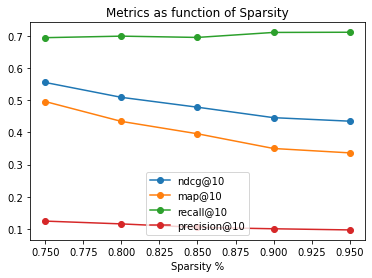

In [32]:
import matplotlib.pyplot as plt
sparsity_levels = list(map(lambda x: float(x), metrics_at_sparsity_levels))
plt.plot(sparsity_levels, list(map(lambda x: x['ndcg'], metrics_at_sparsity_levels.values())), label="ndcg@10", marker = "o")
plt.plot(sparsity_levels, list(map(lambda x: x['map'], metrics_at_sparsity_levels.values())), label="map@10", marker = "o")
plt.plot(sparsity_levels, list(map(lambda x: x['recall'], metrics_at_sparsity_levels.values())), label="recall@10", marker = "o")
plt.plot(sparsity_levels, list(map(lambda x: x['precision'], metrics_at_sparsity_levels.values())), label="precision@10", marker = "o")

plt.title("Metrics as function of Sparsity")
plt.xlabel("Sparsity %")
plt.legend()
plt.savefig("../metrics_over_sparsity.png")
plt.show()

In [33]:
import json
with open('knn_result.json', 'w') as f:
    json.dump(metrics_at_sparsity_levels, f)

In [34]:
import json
with open('knn_result_iterations.json', 'w') as f:
    json.dump(json_dict, f)